In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## Step1. import package

In [ ]:
import torch,torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import random,numpy.random
import pandas as pd

## Step2. Data preprocessing
### Read data and concat it
- here only need to be executed at the fist time we run the program. Since we have run it, so we comment it.

### 2-1. Read all manufacturer txt file and put at one dataframe

In [ ]:
# path = "./fgvc-aircraft-2013b/data/images_manufacturer_trainval.txt"
# path2 = "./fgvc-aircraft-2013b/data/images_manufacturer_test.txt"

# df1 = pd.read_csv(path, on_bad_lines='skip', header = None, sep = " ", names = ["A", "B"])
# df2 = pd.read_csv(path2, on_bad_lines='skip', header = None, sep = " ", names = ["A", "B"])
# df3 = pd.concat([df1, df2])
# df3['A'] = df3['A'].apply(lambda x : '{:0>7}.jpg'.format(x))

# df3['A']


### 2-2. create folder in images file

In [ ]:
# path = './fgvc-aircraft-2013b/data/images/'
# for i in df3['B']:
#     if not os.path.isdir(path + i):
#         os.makedirs(path + i)

### 2-3. classify the data to different types

In [ ]:
# path_img = './fgvc-aircraft-2013b/data/images/'
# for index, row in df3.iterrows():
#     shutil.move(path + row['A'] ,path_img + row['B'] + '/')
        

In [ ]:
# image_size = 64
# batch_size = 128
# stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# DATA_DIR = './fgvc-aircraft-2013b/data/images'

#  Conditional GAN
- Reference : https://blog.csdn.net/stay_zezo/article/details/115736574

--- Start Conditional GAN ---

## Step3. Build model
### 3-1. define the seed so everytime it will produce the same result

In [ ]:
def seed_torch(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch()

### 3-2. set parameters

In [ ]:
n_classes = 20
target_label=4
batch_size = 128
nz = 100 # Noise vector dimension / latent dimension
ndf = 64 # Discriminator depth
ngf = 64 # Generator depth
real_label = 1.0
fake_label = 0.0
start_epoch = 0
nc = 3

### 3-3. build generator model

In [ ]:
netG = nn.Sequential(nn.ConvTranspose2d(nz+n_classes, ngf*8,4, 1,0,   bias=False), nn.BatchNorm2d(ngf*8), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,  bias=False), nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2,inplace=True),
#                      nn.ConvTranspose2d(ngf*4, ngf*4,4,2, 1,bias=False), nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*4, ngf*2,4,2, 1,bias=False), nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*2, ngf*2,4,2, 1,bias=False), nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*2, nc,4,2,1,    bias=False), 
                     nn.Tanh()  #(N,nc, 128,128)
                    )

### 3-4. build discriminator model

In [ ]:
netD = nn.Sequential(nn.Conv2d(nc+n_classes,ndf*2,4,2,1, bias=False), nn.BatchNorm2d(ndf*2),nn.LeakyReLU(0.2,inplace=True),
                     nn.Conv2d(ndf*2,ndf*2,4,2,1, bias=False), nn.BatchNorm2d(ndf*2),nn.LeakyReLU(0.2,inplace=True),
                     nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),nn.BatchNorm2d(ndf*4),nn.LeakyReLU(0.2,inplace=True),
#                      nn.Conv2d(ndf*4,ndf*4,4,2,1,  bias=False),  nn.BatchNorm2d(ndf*4),nn.LeakyReLU(0.2,inplace=True),
                     nn.Conv2d(ndf*4,ndf*8,4,2,1,  bias=False),  nn.BatchNorm2d(ndf*8),nn.LeakyReLU(0.2,inplace=True),
                     nn.Conv2d(ndf*8,1,4,1,0,    bias=False),  #(N,1,1,1)
                     nn.Flatten(),    #(N,1)
                     nn.Sigmoid()
                    )

### 3-5. custom weights initialization called on netG and netD

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

netD.apply(weights_init)
netG.apply(weights_init)

Sequential(
  (0): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2,

### 3-6. load dataset

In [ ]:
apply_transform2 = transforms.Compose([
        transforms.Resize((64,64)), # Resize image to 64x64
        transforms.ToTensor(), # Convert image type to tensor
        transforms.Normalize((0.5,), (0.5,)),
    ])

### 3-7. define loss function and setup optimizer

In [ ]:
criterion = torch.nn.BCELoss()
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002,betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002,betas=(0.5,0.999))
 

In [ ]:
DATA_DIR = './fgvc-aircraft-2013b/data/images'
train_dataset = torchvision.datasets.ImageFolder(root=DATA_DIR,transform=apply_transform2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 3-8. show dataset image

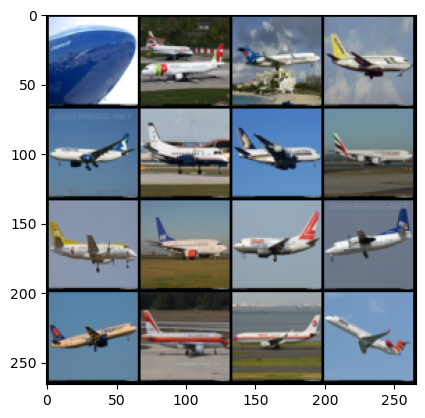

In [ ]:
image, label = next(iter(train_loader))
image = (image*0.5+0.5)[:16]

plt.imshow(torchvision.utils.make_grid(image,nrow=4).permute(1,2,0))

### 3-9. do the one-hot encoder

In [ ]:
lb = LabelBinarizer()
lb.fit(list(range(0,n_classes)))
 
def to_categrical(y: torch.FloatTensor):
    y_one_hot = lb.transform(y.cpu())
    floatTensor = torch.FloatTensor(y_one_hot)
    return floatTensor.to(device)

### 3-10. concat the sample and onehot encoder label

In [ ]:
def concanate_data_label(data, y):  #data （N,nc, 128,128）
    y_one_hot = to_categrical(y)  #(N,1)->(N,n_classes)
    
    con = torch.cat((data, y_one_hot), 1)
    
    return con

## Step4. Start training
### 4-1 load model and continue to train
- You only able to run this after training the data or you have the model saved on your directory (skip this part if you don't have any model)

In [ ]:
checkpoint = torch.load('./checkpoint/GAN_best.pth')
netG.load_state_dict(checkpoint['net_G'])                  
netD.load_state_dict(checkpoint['net_D'])
start_epoch = checkpoint['start_epoch']
print('netG:','\n',netG)
print('netD:','\n',netD)
    
print('training on:   ',device, '   start_epoch',start_epoch)

netG: 
 Sequential(
  (0): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), st

### 4-2. start training

In [ ]:
netD, netG = netD.to(device), netG.to(device)

for epoch in range(start_epoch, 60):
    for batch, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        target1 = to_categrical(target).unsqueeze(2).unsqueeze(3).float()  
        target2 = target1.repeat(1, 1, data.size(2), data.size(3))   
        data = torch.cat((data, target2),dim=1)  
        label = torch.full((data.size(0),1), real_label).to(device)
  
        netD.zero_grad()
        output = netD(data)
        loss_D1 = criterion(output, label)
        loss_D1.backward()
      
        noise_z = torch.randn(data.size(0), nz, 1, 1).to(device)
        noise_z = torch.cat((noise_z, target1),dim=1) #(N,nz+n_classes,1,1)

        fake_data = netG(noise_z)
        fake_data = torch.cat((fake_data,target2),dim=1) #(N,nc+n_classes,128,128)
        label = torch.full((data.size(0),1), fake_label).to(device)
    
        output = netD(fake_data.detach())
        loss_D2 = criterion(output, label)
        loss_D2.backward()
        optimizerD.step()
        
        netG.zero_grad()
        label = torch.full((data.size(0),1), real_label).to(device)
        output = netD(fake_data.to(device))
        lossG = criterion(output, label)
        lossG.backward()
        
        optimizerG.step()
        
        if batch %10==0:
            print('epoch: %4d, batch: %4d, discriminator loss: %.4f, generator loss: %.4f'
                  %(epoch, batch, loss_D1.item()+loss_D2.item(), lossG.item()))
        
        if epoch%2==0 and batch==0:
            noise_z1 = torch.randn(data.size(0), nz, 1, 1).to(device)
            target3 = to_categrical(torch.full((data.size(0),1), target_label)).unsqueeze(2).unsqueeze(3).float()  #加到噪声上
            noise_z = torch.cat((noise_z1, target3),dim=1) #(N,nz+n_classes,1,1) 
            fake_data = netG(noise_z.to(device))
            if nc ==1:
                fake_data=torch.cat((fake_data,fake_data,fake_data),dim=1)   #fake_data（N,1,H,W）->(N,3,H,W)
            data = fake_data.detach().cpu().permute(0,2,3,1)
            data = np.array(data)
            data = (data*0.5+0.5)
            plt.imsave(f'./generated_fake/epoch_{epoch}.png', data[0])
            torchvision.utils.save_image(fake_data[:16]*0.5+0.5, fp=f'./generated_fake/epoch_{epoch}_grid.png',nrow=4,normalize=True)

epoch:   50, batch:    0, discriminator loss: 0.3969, generator loss: 0.1841
epoch:   50, batch:   10, discriminator loss: 0.2498, generator loss: 3.2225
epoch:   50, batch:   20, discriminator loss: 0.1805, generator loss: 4.1226
epoch:   50, batch:   30, discriminator loss: 0.7640, generator loss: 3.6448
epoch:   50, batch:   40, discriminator loss: 0.2424, generator loss: 3.4399
epoch:   50, batch:   50, discriminator loss: 0.1862, generator loss: 3.0599
epoch:   51, batch:    0, discriminator loss: 0.1293, generator loss: 3.7526
epoch:   51, batch:   10, discriminator loss: 0.1146, generator loss: 5.0173
epoch:   51, batch:   20, discriminator loss: 0.4705, generator loss: 1.6072
epoch:   51, batch:   30, discriminator loss: 0.2384, generator loss: 3.6432
epoch:   51, batch:   40, discriminator loss: 0.3091, generator loss: 3.0158
epoch:   51, batch:   50, discriminator loss: 0.5849, generator loss: 8.0596
epoch:   52, batch:    0, discriminator loss: 0.1976, generator loss: 3.3679

### 4-3. save model 

In [ ]:
state = {
            'net_G': netG.state_dict(),
            'net_D': netD.state_dict(),
            'start_epoch':epoch+1
        }
torch.save(state, './checkpoint/GAN_best1.pth')
torch.save(state, './checkpoint/GAN_best_copy1.pth')

## Step5. Generate Fake Image
- if we already trained the model, we can run this section to start generating fake image

### 5-1. import package

In [ ]:
import torch,torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import random,numpy.random
import os

### 5-2. set parameters

In [ ]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
n_classes = 20
target_label=4
batch_size = 128
nz = 100 # Noise vector dimension
ndf = 64 # Discriminator depth
ngf = 64 # Generator depth
real_label = 1.0
fake_label = 0.0
start_epoch = 0
nc = 3

### 5-3. do the generator function
- just same as above, we need generator function to generate the image so we need to write this function again

In [ ]:
netG = nn.Sequential(nn.ConvTranspose2d(nz+n_classes, ngf*8,4, 1,0,   bias=False), nn.BatchNorm2d(ngf*8), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,  bias=False), nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2,inplace=True),
#                      nn.ConvTranspose2d(ngf*4, ngf*4,4,2, 1,bias=False), nn.BatchNorm2d(ngf*4), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*4, ngf*2,4,2, 1,bias=False), nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*2, ngf*2,4,2, 1,bias=False), nn.BatchNorm2d(ngf*2), nn.LeakyReLU(0.2,inplace=True),
                     nn.ConvTranspose2d(ngf*2, nc,4,2,1,    bias=False), 
                     nn.Tanh()  #(N,nc, 128,128)
                    )

### 5-4. load model

In [ ]:
checkpoint = torch.load('drive/MyDrive/AI_final_share/generate/checkpoint/GAN_best1.pth')
netG.load_state_dict(checkpoint['net_G'])               

<All keys matched successfully>

### 5-5 do one-hot encoder

In [ ]:
lb = LabelBinarizer()
lb.fit(list(range(0,n_classes)))
 
def to_categrical(y: torch.FloatTensor):
    y_one_hot = lb.transform(y.cpu())
    floatTensor = torch.FloatTensor(y_one_hot)
    return floatTensor.to(device)

### 5-6. load dataset

In [ ]:
apply_transform2 = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])

DATA_DIR = 'drive/MyDrive/AI_final_share/generate/fgvc-aircraft-2013b/data/images'
train_dataset = torchvision.datasets.ImageFolder(root=DATA_DIR,transform=apply_transform2) 

### 5-7. generate the image

In [ ]:
nz = 100
dataS = 10
netG = netG.to(device)
for target_label, class_name in enumerate(train_dataset.classes):
    noise_z1 = torch.randn(dataS, nz, 1, 1).to(device) 
    target = to_categrical(torch.full((dataS,1), target_label)).unsqueeze(2).unsqueeze(3).float() 
    noise_z = torch.cat((noise_z1, target),dim=1)
    
    fake_data = netG(noise_z.to(device))
    
    data = fake_data.detach().cpu().permute(0,2,3,1)
    data = np.array(data)

    data = (data*0.5+0.5)
    for i in range(10):
        path = f'drive/MyDrive/AI_final_share/generate/group26/{class_name}'
        if not os.path.isdir(path):
            os.makedirs(path)
        plt.imsave(f'{path}/{i+1}.jpg', data[i])

--- End Conditional GAN ---